<a href="https://colab.research.google.com/github/Juancard/multi-label-classification-on-data-streamings/blob/master/20ng_entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

##Instalacion

In [1]:
!pip install --upgrade pip
!pip install numpy
!pip uninstall -y scikit-learn && pip install sklearn
!pip install scikit-multilearn && pip install --upgrade scikit-multiflow
!pip install liac-arff
!pip install requests
!pip install seaborn
!pip install scikit-multiflow


Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2)
Found existing installation: scikit-learn 0.23.1
Uninstalling scikit-learn-0.23.1:
  Successfully uninstalled scikit-learn-0.23.1
  Using cached scikit_learn-0.23.1-cp36-cp36m-manylinux1_x86_64.whl (6.8 MB)
Requirement already up-to-date: scikit-multiflow in /usr/local/lib/python3.6/dist-packages (0.5.3)


##Dependencias

In [2]:
import os, sys, time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from matplotlib import pyplot as plt
from skmultilearn.dataset import load_dataset, load_from_arff
from skmultilearn.utils import measure_per_label
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss, precision_recall_fscore_support, log_loss
from skmultiflow.metrics import hamming_score, exact_match, j_index
from skmultiflow.meta.multi_output_learner import MultiOutputLearner
from skmultiflow.meta import ClassifierChain
from skmultiflow.trees import LabelCombinationHoeffdingTreeClassifier
from skmultiflow.core.pipeline import Pipeline
from skmultiflow.data.data_stream import DataStream
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import ConceptDriftStream, MultilabelGenerator

#TESIS_DIR="/content/drive/My Drive/tesis_cardona_mll_streaming"
TESIS_DIR="../"

##Funciones mias


In [3]:
from sklearn.datasets import make_multilabel_classification
from skmultiflow.utils import check_random_state
class MultilabelGenerator2( MultilabelGenerator ):
    # IGUAL QUE LA FUNCION ORIGINAL PERO NO PERMITE INSTANCIAS SIN ETIQUETAS
    def _prepare_for_use(self):
        print("Preparando Generador Multietiquetas v2")
        self._random_state = check_random_state(self.random_state)
        self.X, self.y = make_multilabel_classification(n_samples=self.n_samples,
                                                        n_features=self.n_features,
                                                        n_classes=self.n_targets,
                                                        n_labels=self.n_labels,
                                                        allow_unlabeled=False, ## SE AGREGA ESTA LINEA 
                                                        random_state=self._random_state)
        self.target_names = ["target_" + str(i) for i in range(self.n_targets)]
        self.feature_names = ["att_num_" + str(i) for i in range(self.n_num_features)]
        self.target_values = np.unique(self.y).tolist() if self.n_targets == 1 else \
            [np.unique(self.y[:, i]).tolist() for i in range(self.n_targets)]
    # por alguna razón la clase MultilabelGenerator no implementa el método has_more_classes
    def has_more_samples( self ):
        return self.n_remaining_samples() > 0
class ConceptDriftStream2(ConceptDriftStream):
    def prob_drift( self, batch_size=1):
        x = -4.0 * float(self.sample_idx - self.position) / float(self.width)
        probability_drift = 1.0 / (1.0 + np.exp(x))
        x, y = super().next_sample(batch_size)
        return probability_drift
    def next_sample(self, batch_size=1):
      """
        Copio y pego textual de next_sample. 
        Solo quito el planchado realizado sobre la matriz de etiquetas.
        "self.current_sample_y.flatten()" pasa a ser "self.current_sample_y"
      """
      self.current_sample_x = np.zeros((batch_size, self.n_features))
      self.current_sample_y = np.zeros((batch_size, self.n_targets))
      for j in range(batch_size):
          self.sample_idx += 1
          x = -4.0 * float(self.sample_idx - self.position) / float(self.width)
          probability_drift = 1.0 / (1.0 + np.exp(x))
          if self._random_state.rand() > probability_drift:
              X, y = self.stream.next_sample()
          else:
              X, y = self.drift_stream.next_sample()
          self.current_sample_x[j, :] = X
          self.current_sample_y[j, :] = y
      return self.current_sample_x, self.current_sample_y

def label_based_accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the label-based accuracy for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def evaluate_prequential(stream, model, pretrain_size=0.1, window_size=20):
  stream.restart()
  pretrain_samples = round(stream.n_remaining_samples() * pretrain_size)
  batch_size = round((stream.n_remaining_samples() - pretrain_samples) / window_size)
  print("Pretrain size (examples):", pretrain_samples)
  print("Batch size (examples):", batch_size)
  evaluator = EvaluatePrequential(
      show_plot=True, 
      pretrain_size=pretrain_samples, 
      batch_size=batch_size,
      max_samples=1000000,
      metrics=["exact_match", "hamming_score", "hamming_loss", "j_index", "running_time", "model_size"],
      output_file='results_br_stream_no_drift.csv'
  )
  evaluator.evaluate(stream=stream, model=model)

def evaluar(stream, model, pretrain_size=0.1, window_size=20):
  stream.restart()
  
  pretrain_size=round(stream.n_remaining_samples() * pretrain_size)
  print("Pretrain size: ", pretrain_size)
  start_time = time.time()

  # Pre training the classifier
  X, y = stream.next_sample(pretrain_size)
  model.partial_fit(X, y, classes=stream.target_values)

  print("Train size: ", stream.n_remaining_samples())
  batch_size=round(stream.n_remaining_samples() / window_size)
  print("Batch size: ", batch_size)

  # Keeping track of sample count, true labels and predictions to later
  # compute the classifier's hamming score
  iterations = 0
  true_labels = []
  predicts = []

  while stream.has_more_samples():
      X, y = stream.next_sample(batch_size)
      y_pred = model.predict(X)
      model.partial_fit(X, y)
      predicts.extend(y_pred)
      true_labels.extend(y)
      iterations += 1
  end_time = time.time()
  print('Iterations: ', iterations)
  print("Hamming score: ", hamming_score(true_labels, predicts))
  print("hamming loss: ", hamming_loss(true_labels, predicts))
  print("Exact Match (aka, 0/1-loss): ", exact_match(true_labels, predicts))
  print("Accuracy (exampled-based, igual que exact match): ", accuracy_score(true_labels, predicts))
  print("Accuracy (label-based): ", label_based_accuracy(np.array(true_labels), np.array(predicts)))
  print("Accuracy per label: ", measure_per_label(accuracy_score, sparse.csr_matrix(true_labels), sparse.csr_matrix(predicts)))
  print("Jaccard Index: ", j_index(true_labels, predicts))
  print("Log loss: ", log_loss(true_labels, predicts))
  print("precision_recall_fscore_support (samples): ", precision_recall_fscore_support(true_labels, predicts, average="samples"))
  print("precision_recall_fscore_support (weighted): ", precision_recall_fscore_support(true_labels, predicts, average="weighted"))
  print("precision_recall_fscore_support (micro): ", precision_recall_fscore_support(true_labels, predicts, average="micro"))
  print("precision_recall_fscore_support (macro): ", precision_recall_fscore_support(true_labels, predicts, average="macro"))
  print("Time: {} seconds.".format(end_time - start_time))

def label_skew_graph(y_array, color="red", plot_labels=-1, print_top=10):
  df = pd.DataFrame(y_array, columns=[i for i in range(0,y_array.shape[1])])
  labels_set_count = df.groupby(df.columns.tolist(),as_index=False).size().sort_values(ascending=False)
  print("Top ",print_top,": \n", labels_set_count[:print_top])
  labels_set_count_scaled = (labels_set_count-labels_set_count.min())/(labels_set_count.max()-labels_set_count.min())
  sns.lineplot(data=labels_set_count_scaled.values[:plot_labels], color=color)

def labels_distribution_graph(y_array, color="red", print_top=5):
  df = pd.DataFrame(y_array, columns=[i for i in range(0,y_array.shape[1])])
  labels_distribution = df.sum(axis=1).value_counts().sort_index()
  print("Número de etiquetas por instancia vs frecuencia - ",print_top, "\n", labels_distribution[:print_top])
  labels_distribution_scaled = (labels_distribution-labels_distribution.min())/(labels_distribution.max()-labels_distribution.min())
  #print("Número de etiquetas por instancia vs frecuencia (escalada)\n", labels_distribution_scaled)
  sns.lineplot(data=labels_distribution_scaled, color=color)

def load_syn_stream(filepath, labels):
  with open(filepath) as arff_file:
    arff_file_content = [line.rstrip(",\n") + "\n" for line in arff_file]
    with open("/tmp/stream", "w") as f:
      f.write("".join(arff_file_content))
  arff_path = "/tmp/stream"
  label_location="start"
  arff_file_is_sparse = False
  X_mulan, y_mulan, feature_names, label_names = load_from_arff(
    arff_path, 
    labels,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
  )
  return X_mulan, y_mulan, feature_names, label_names

##Monta drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Streams

In [4]:
def load_20ng_dataset():
  arff_path = os.path.join(TESIS_DIR, "datasets/20ng/meka/20NG-F.arff")
  N_LABELS = 20
  label_location="start"
  arff_file_is_sparse = False
  X_mulan, y_mulan, feature_names, label_names = load_from_arff(
    arff_path, 
    N_LABELS,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
  )
  return X_mulan, y_mulan, feature_names, label_names

##Original

In [5]:
X_stream, y_stream, feature_names, label_names = load_20ng_dataset()
stream_original = DataStream(data=X_stream.todense(), y=y_stream.todense(), name="20ng")
stream_original.n_remaining_samples(), X_stream, y_stream

(19300, <19300x1006 sparse matrix of type '<class 'numpy.float64'>'
 	with 619079 stored elements in LInked List format>, <19300x20 sparse matrix of type '<class 'numpy.int64'>'
 	with 19857 stored elements in LInked List format>)

## Sintético skmultiflow

In [8]:
labels_por_instancia = y_stream.sum(axis=1).mean()
print("Cardinalidad:", labels_por_instancia)
stream_syn_skm = MultilabelGenerator2(
  n_features=stream_original.n_features, 
  n_targets=stream_original.n_targets, 
  n_labels=1,#labels_por_instancia,
  n_samples=stream_original.n_remaining_samples() * 2
)
print("Cantidad de instancias:", stream_syn_skm.n_remaining_samples())
print("Targets: ", stream_syn_skm.target_names)

Cardinalidad: 1.028860103626943
Preparando Generador Multietiquetas v2
Cantidad de instancias: 38600
Targets:  ['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_8', 'target_9', 'target_10', 'target_11', 'target_12', 'target_13', 'target_14', 'target_15', 'target_16', 'target_17', 'target_18', 'target_19']


## Sintético MOA

In [9]:
labels = y_stream.get_shape()[1]
filepath = os.path.join(TESIS_DIR, "streams/20ng_syn_19300_skew0_ld25_card0_5.arff")
X_moa_syn, y_moa_syn, feature_names, label_names = load_syn_stream(filepath, labels)
stream_syn_moa = DataStream(data=X_moa_syn.todense(), y=y_moa_syn.todense(), name="20ng_syn_moa")
stream_syn_moa.n_remaining_samples()

KeyboardInterrupt: ignored

# Clasificaciones

##Original

### Binary Relevance

Pretrain size (examples): 1930
Batch size (examples): 868


<IPython.core.display.Javascript object>


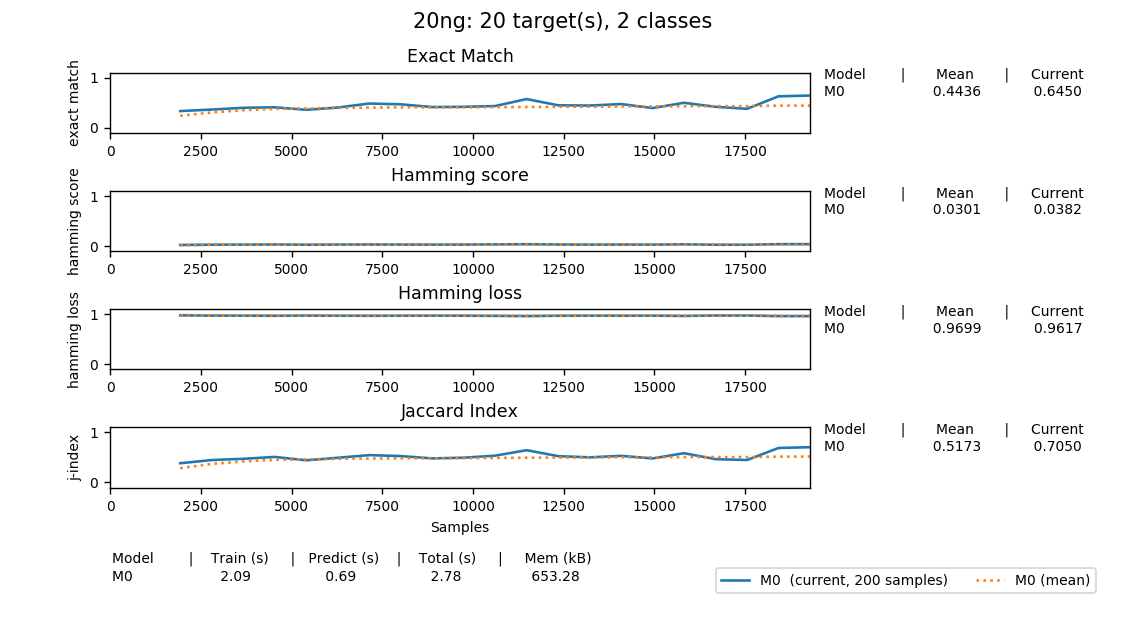

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 1930 sample(s).
Evaluating...
 #################### [100%] [11.81s]
Processed samples: 20158
Mean performance:
M0 - Hamming score: 0.0301
M0 - Hamming loss : 0.9699
M0 - Exact matches: 0.4436
M0 - Jaccard index: 0.5173
M0 - Training time (s)  : 2.09
M0 - Testing time  (s)  : 0.69
M0 - Total time    (s)  : 2.78
M0 - Size (kB)          : 653.2764


In [6]:
%matplotlib notebook
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluate_prequential(stream_original, classifier_br, 0.1)
stream_original.restart()

In [ ]:
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluar(stream_original, classifier_br, 0.1)
stream_original.restart()

### Classifier Chains

Pretrain size (examples): 1930
Batch size (examples): 868


<IPython.core.display.Javascript object>


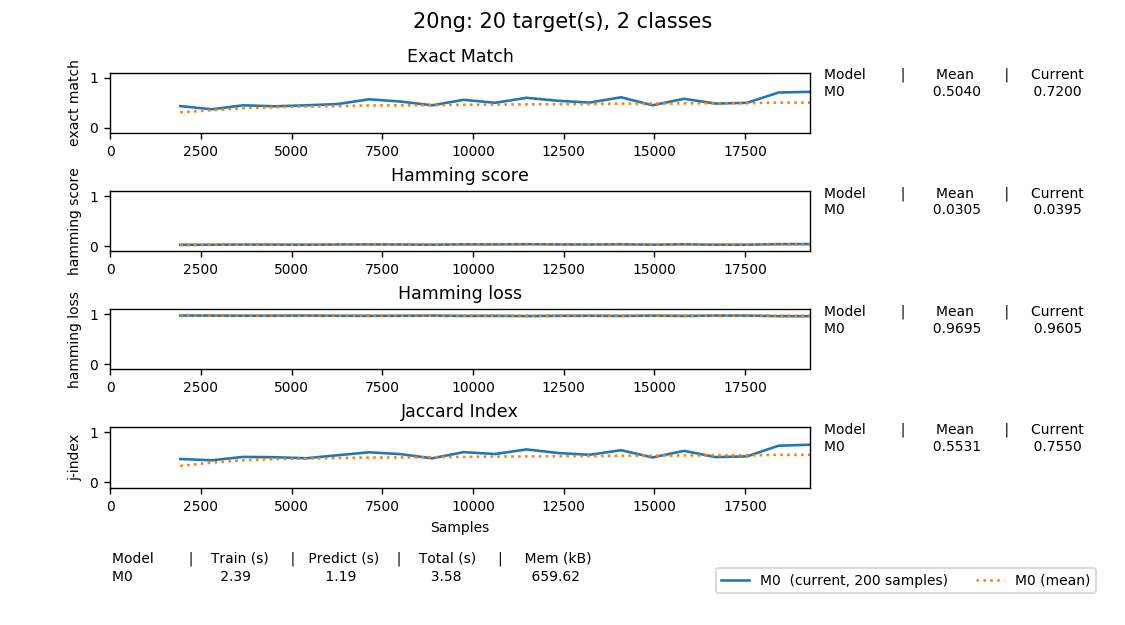

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 1930 sample(s).
Evaluating...
 #################### [100%] [12.29s]
Processed samples: 20158
Mean performance:
M0 - Hamming score: 0.0305
M0 - Hamming loss : 0.9695
M0 - Exact matches: 0.5040
M0 - Jaccard index: 0.5531
M0 - Training time (s)  : 2.39
M0 - Testing time  (s)  : 1.19
M0 - Total time    (s)  : 3.58
M0 - Size (kB)          : 659.6191


In [7]:
%matplotlib notebook
classifier_cc = ClassifierChain(
    Perceptron()
)
evaluate_prequential(
    stream_original, 
    classifier_cc,
    0.1
)
stream_original.restart()

In [ ]:
classifier_cc = ClassifierChain(
    Perceptron()
)
evaluar(
    stream_original, 
    classifier_cc,
    0.1
)
stream_original.restart()

### Label Combination Hoeffding Tree

In [ ]:
%matplotlib notebook
classifier_lcht = LabelCombinationHoeffdingTreeClassifier(n_labels=stream_original.n_targets)
evaluate_prequential(
    stream_original, 
    classifier_lcht,
    1000 / stream_original.n_remaining_samples()# READ(2012) recomienda entrenar con 1000 ejemplos (o cualquier valor del rango 500-1500)
)
stream_original.restart()

Pretrain size (examples): 1000
Batch size (examples): 915


<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 1000 sample(s).
Evaluating...


In [ ]:
classifier_lcht = LabelCombinationHoeffdingTreeClassifier(n_labels=stream_original.n_targets)
evaluar(
    stream_original, 
    classifier_lcht,
    1000 / stream_original.n_remaining_samples()# READ(2012) recomienda entrenar con 1000 ejemplos (o cualquier valor del rango 500-1500)
)
stream_original.restart()

In [ ]:
cat /proc/sys/vm/overcommit_memory
